## 🔐 Cyber Attack Detection using Machine Learning

With the rapid increase in internet usage, cyber attacks have become a major threat to digital systems. Traditional intrusion detection systems often fail to detect complex and evolving attack patterns. The objective of this project is to build a machine learning-based Cyber Attack Detection System that can classify network traffic into different categories of attacks such as DoS(Denial of Service), Probe, R2L(Remote to Local), U2R(User to Normal), or Normal. By analyzing features from network data, the system aims to detect malicious behavior accurately and in real-time, thereby helping to secure networks from potential breaches.

This project focuses on building a machine learning model to detect various types of cyber attacks based on network traffic features. The process involves data cleaning, preprocessing, model training, evaluation, and deployment using an XGBoost classifier.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv('cyber_attack_cleaned_combined_data.csv')
df.head()

,Unnamed: 0,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,nsl_label,attack_class
0,0,0,tcp,ftp_data,SF,491,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,U2R
1,1,0,udp,other,SF,146,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,U2R
2,2,0,tcp,private,S0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,U2R
3,3,0,tcp,http,SF,232,8153,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,U2R
4,4,0,tcp,http,SF,199,420,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,U2R


In [2]:
# Drop the 'Unnamed: 0' column
df = df.drop(columns=['Unnamed: 0'])


In [3]:
print(df.columns)


Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'nsl_label', 'attack_class'],
      dtype='object')


In [4]:
# Select relevant features
selected_features = [
    'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'logged_in', 'count', 'srv_count', 'same_srv_rate', 'diff_srv_rate', 'attack_class'
]
df = df[selected_features]

## 🧠 Exploratory Data Analysis
We inspect the shape, column names, and datatypes to understand what preprocessing steps will be necessary. We also analyze the class distribution and correlation between class labels with different features selected. This helps us decide how to encode categorical features and handle imbalances.


In [5]:
# Basic info
display("Dataset shape:",df.shape)
display("Data Types of selected features:",df.dtypes)
display("First 5 rows of the dataset with selected features:", df.head())

'Dataset shape:'

(125973, 11)

'Data Types of selected features:'

protocol_type     object
service           object
flag              object
src_bytes          int64
dst_bytes          int64
logged_in          int64
count              int64
srv_count          int64
same_srv_rate    float64
diff_srv_rate    float64
attack_class      object
dtype: object

'First 5 rows of the dataset with selected features:'

,protocol_type,service,flag,src_bytes,dst_bytes,logged_in,count,srv_count,same_srv_rate,diff_srv_rate,attack_class
0,tcp,ftp_data,SF,491,0,0,2,2,1.00,0.00,U2R
1,udp,other,SF,146,0,0,13,1,0.08,0.15,U2R
2,tcp,private,S0,0,0,0,123,6,0.05,0.07,U2R
3,tcp,http,SF,232,8153,1,5,5,1.00,0.00,U2R
4,tcp,http,SF,199,420,1,30,32,1.00,0.00,U2R


In [6]:
# Null values
print("Missing values:")
display(df.isnull().sum())

Missing values:


protocol_type    0
service          0
flag             0
src_bytes        0
dst_bytes        0
logged_in        0
count            0
srv_count        0
same_srv_rate    0
diff_srv_rate    0
attack_class     0
dtype: int64

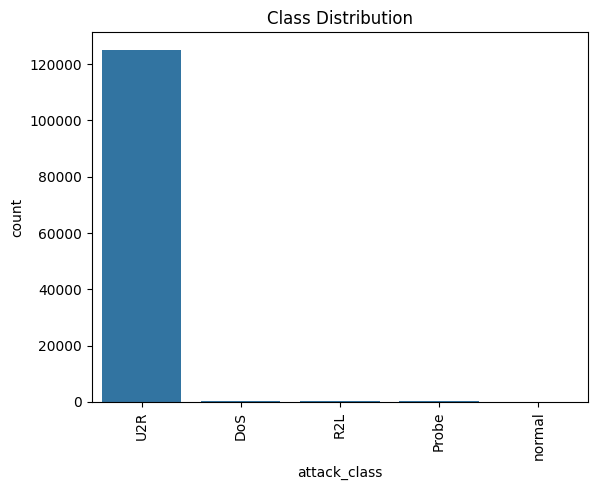

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution
sns.countplot(data=df, x='attack_class')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

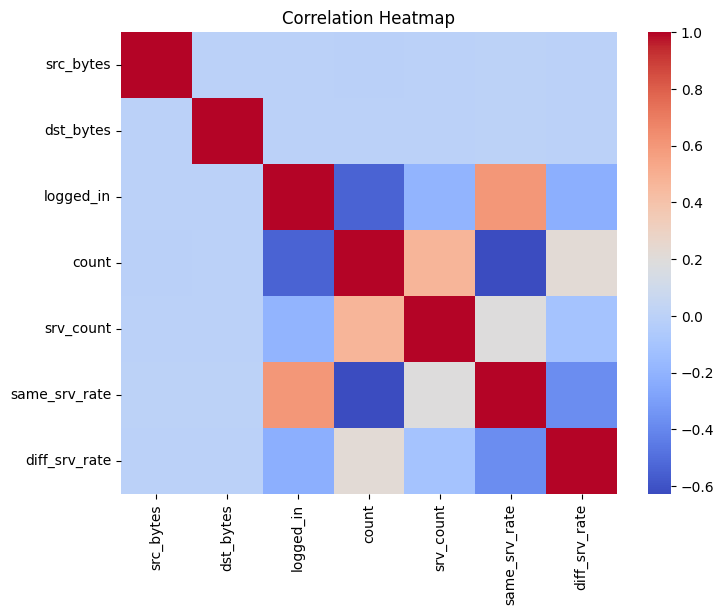

In [8]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

## 🔠 Label Encoding for Categorical Features
Categorical columns such as `protocol_type`, `service`, and `flag` are label-encoded using `LabelEncoder`. This is essential since machine learning models only accept numerical values.


In [9]:
# Encode categorical features
protocol_le = LabelEncoder()
service_le = LabelEncoder()
flag_le = LabelEncoder()

df['protocol_type'] = protocol_le.fit_transform(df['protocol_type'])
df['service'] = service_le.fit_transform(df['service'])
df['flag'] = flag_le.fit_transform(df['flag'])

In [10]:
import joblib
joblib.dump(protocol_le, 'protocol_encoder.joblib')
joblib.dump(service_le, 'service_encoder.joblib')
joblib.dump(flag_le, 'flag_encoder.joblib')


['flag_encoder.joblib']

In [11]:
# Encode target labels and save encoder with correct mapping
label_encoder = LabelEncoder()
df['attack_class'] = label_encoder.fit_transform(df['attack_class'])

# Save it right here (correct place)
joblib.dump(label_encoder, "attack_class_encoder_model.joblib")

['attack_class_encoder_model.joblib']

In [12]:
# Split features and target
X = df.drop('attack_class', axis=1)
y = df['attack_class']


## ⚖️ Handle Class Imbalance with SMOTE
We apply SMOTE (Synthetic Minority Oversampling Technique) to generate synthetic samples for minority classes. This balances the class distribution and improves model learning.


In [13]:
# Balance data using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42)

In [15]:
# Export to CSV
X_train.to_csv("X_Train.csv", index=False)
X_test.to_csv("X_Test.csv", index=False)
y_train.to_csv("y_Train.csv", index=False)
y_test.to_csv("y_Test.csv", index=False)

print("Exported: X_Train.csv, X_Test.csv, y_Train.csv, y_Test.csv")

Exported: X_Train.csv, X_Test.csv, y_Train.csv, y_Test.csv


In [16]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# Load training/testing sets
X_train = pd.read_csv("X_Train.csv")
X_test = pd.read_csv("X_Test.csv")
y_train = pd.read_csv("y_Train.csv").squeeze()  # to Series
y_test = pd.read_csv("y_Test.csv").squeeze()

print("Datasets loaded successfully.")

Datasets loaded successfully.


## 🚂 Training XGBoost Classifier
We train a powerful gradient boosting model, XGBoost, which is highly efficient for classification tasks. Hyperparameters like learning rate, max depth, and number of estimators are selected to optimize performance.

In [17]:
#Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(label_encoder.classes_),
    eval_metric="mlogloss",
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    seed=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1, num_class=5, ...)

## 📊 Evaluating the Model
We use accuracy, precision, recall, F1-score, and a confusion matrix to evaluate how well the model performs on unseen test data.


In [18]:
# Evaluate xgboost model
# -----------------------------
# y_test is encoded integers, so decode it
y_test_labels = label_encoder.inverse_transform(y_test)

# Predict and decode predictions
y_pred = xgb_model.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# All labels are now decoded strings (e.g., "DoS", "Probe", etc.)
print("Model Evaluation:")
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels)*100)
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))
print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))

Model Evaluation:
Accuracy: 86.21133608418897
Classification Report:
               precision    recall  f1-score   support

         DoS       0.86      0.76      0.81     25011
       Probe       0.79      0.83      0.81     25010
         R2L       0.85      0.79      0.82     25010
         U2R       0.98      0.94      0.96     25011
      normal       0.84      0.99      0.91     25010

    accuracy                           0.86    125052
   macro avg       0.86      0.86      0.86    125052
weighted avg       0.86      0.86      0.86    125052

Confusion Matrix:
 [[18966  2250   790    67  2938]
 [ 1881 20770  2106   130   123]
 [  662  2734 19862   278  1474]
 [  343   614   335 23472   247]
 [  107     2   155     7 24739]]


In [19]:
# Save the model
joblib.dump(xgb_model, "cyber_instrusion_model.joblib")

['cyber_instrusion_model.joblib']

## 🔮 Generating and Predicting on Real World Data

We examined a "real-world-like" dataset by adding slight noise to actual data. This simulates unseen data for testing model robustness. Predictions are made and decoded back to original class labels using saved encoders.



In [20]:
# Show sample predictions
example_df = pd.DataFrame({
    "Actual": y_test[:10].values,
    "Predicted": y_pred_labels[:10]
})
print("\nSample Predictions:\n", example_df)



Sample Predictions:
    Actual Predicted
0       3       U2R
1       4    normal
2       1     Probe
3       2       R2L
4       3       U2R
5       4    normal
6       2       R2L
7       2       R2L
8       3       U2R
9       2    normal


In [21]:
# Generate new synthetic "real-world" data

X_train_sample = X_train.sample(10, random_state=42)
X_test_sample = X_test.sample(10, random_state=42)
new_data = pd.concat([X_train_sample, X_test_sample], axis=0).reset_index(drop=True)

# Introduce slight noise
noise = np.random.normal(0, 0.1, new_data.shape)
new_data_noisy = new_data + noise
new_data_noisy = new_data_noisy.abs()

# Clip numeric values to expected range
numeric_columns = new_data.columns.tolist()
new_data_noisy[numeric_columns] = new_data_noisy[numeric_columns].clip(lower=0, upper=10000)

# Save synthetic new data
new_data_noisy.to_csv("real_world_data.csv", index=False)
print("Synthetic data saved to 'real_world_data.csv'.")

Synthetic data saved to 'real_world_data.csv'.


In [22]:
import pandas as pd
import joblib

# Load the real-world data
df = pd.read_csv("real_world_data.csv")

# Load the saved encoders
protocol_encoder = joblib.load("protocol_encoder.joblib")
service_encoder = joblib.load("service_encoder.joblib")
flag_encoder = joblib.load("flag_encoder.joblib")

# Decode
df['protocol_type'] = protocol_encoder.inverse_transform(df['protocol_type'].astype(int))
df['service'] = service_encoder.inverse_transform(df['service'].astype(int))
df['flag'] = flag_encoder.inverse_transform(df['flag'].astype(int))

# Save decoded version
df.to_csv("decoded_real_world_data.csv", index=False)
print("Decoded dataset saved.")


Decoded dataset saved.


In [23]:
# Predict on new unseen data
# Method 1: Without using decoded real world dataset

model = joblib.load("cyber_instrusion_model.joblib")
label_encoder = joblib.load("attack_class_encoder_model.joblib")
new_data = pd.read_csv("real_world_data.csv")

# Predict
new_preds = model.predict(new_data)
decoded_preds = label_encoder.inverse_transform(new_preds)

# Add predictions to DataFrame
new_data["Predicted_Class"] = decoded_preds

# Show results
print("\nPredictions on synthetic data:")
print(new_data[["Predicted_Class"]])

# Show frequency of predicted classes
print("\nPredicted class distribution:")
print(new_data["Predicted_Class"].value_counts())


Predictions on synthetic data:
   Predicted_Class
0              DoS
1              U2R
2              U2R
3              R2L
4              R2L
5              DoS
6            Probe
7              R2L
8              R2L
9           normal
10             DoS
11           Probe
12           Probe
13           Probe
14             R2L
15             R2L
16             R2L
17             R2L
18           Probe
19             DoS

Predicted class distribution:
Predicted_Class
R2L       8
Probe     5
DoS       4
U2R       2
normal    1
Name: count, dtype: int64


In [24]:
# Method 2: Using real world decoded dataset

# Load real-world decoded data
df = pd.read_csv("decoded_real_world_data.csv")

# Load saved encoders
protocol_le = joblib.load("protocol_encoder.joblib")
service_le = joblib.load("service_encoder.joblib")
flag_le = joblib.load("flag_encoder.joblib")
label_encoder = joblib.load("attack_class_encoder_model.joblib")  # For decoding

# Encode categorical features using saved encoders
df['protocol_type'] = protocol_le.transform(df['protocol_type'])
df['service'] = service_le.transform(df['service'])
df['flag'] = flag_le.transform(df['flag'])

# Ensure feature columns align with training data
X_train = pd.read_csv("X_train.csv")
df = df.reindex(columns=X_train.columns, fill_value=0)

# Load trained model
model = joblib.load("cyber_instrusion_model.joblib")

# Predict
predictions = model.predict(df)

# Decode predictions to original class labels
decoded_preds = label_encoder.inverse_transform(predictions)

# Append to dataframe
df["Predicted_Class"] = decoded_preds

# Show predictions
print("\nPredictions on Real-World Data (Decoded Labels):")
print(df[["Predicted_Class"]].head(20))

print("\nPredicted Class Distribution:")
print(df["Predicted_Class"].value_counts())


Predictions on Real-World Data (Decoded Labels):
   Predicted_Class
0              DoS
1              U2R
2              U2R
3              R2L
4              R2L
5              DoS
6            Probe
7              R2L
8              R2L
9           normal
10             DoS
11           Probe
12           Probe
13           Probe
14             R2L
15             R2L
16             R2L
17             R2L
18           Probe
19             DoS

Predicted Class Distribution:
Predicted_Class
R2L       8
Probe     5
DoS       4
U2R       2
normal    1
Name: count, dtype: int64


In [25]:
# Save results
df.to_csv("final_predictions_decoded.csv", index=False)
print("Label classes:", label_encoder.classes_)


Label classes: ['DoS' 'Probe' 'R2L' 'U2R' 'normal']


## 🧪Predict on Manual User Inputs


A prediction function is created that:
- Accepts a dictionary of values (user input)
- Encodes categorical features
- Orders the features correctly
- Predicts the attack class
This allows us to test custom inputs for live predictions.


In [26]:
# Method 3: Manual Inputs

# Load encoders and model
protocol_encoder = joblib.load("protocol_encoder.joblib")
service_encoder = joblib.load("service_encoder.joblib")
flag_encoder = joblib.load("flag_encoder.joblib")
label_encoder = joblib.load("attack_class_encoder_model.joblib")
model = joblib.load("cyber_instrusion_model.joblib")

# Expected features in correct order
feature_order = [
    'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'logged_in', 'count', 'srv_count', 'same_srv_rate', 'diff_srv_rate'
]

def predict_attack(user_input):
    """
    Takes raw user input (dict), preprocesses it, and returns a prediction.
    """
    try:
        # Convert to DataFrame
        df = pd.DataFrame([user_input])

        # Encode categorical features
        df['protocol_type'] = protocol_encoder.transform(df['protocol_type'])
        df['service'] = service_encoder.transform(df['service'])
        df['flag'] = flag_encoder.transform(df['flag'])

        # Reorder features
        df = df[feature_order]

        # Make prediction
        pred_encoded = model.predict(df)
        pred_decoded = label_encoder.inverse_transform(pred_encoded)

        return pred_decoded[0]
    
    except Exception as e:
        return f"Error: {str(e)}"

# Example usage with 5 manual inputs
if __name__ == "__main__":
    sample_inputs = [
        {
            "protocol_type": "tcp",
            "service": "smtp",
            "flag": "SF",
            "src_bytes": 6,
            "dst_bytes": 123,
            "logged_in": 1,
            "count": 8,
            "srv_count": 1,
            "same_srv_rate": 0.12,
            "diff_srv_rate": 1.0
        },
        {
            "protocol_type": "udp",
            "service": "domain_u",
            "flag": "S0",
            "src_bytes": 105,
            "dst_bytes": 146,
            "logged_in": 0,
            "count": 2,
            "srv_count": 2,
            "same_srv_rate": 1.0,
            "diff_srv_rate": 0.0
        },
        {
            "protocol_type": "icmp",
            "service": "urp_i",
            "flag": "SF",
            "src_bytes": 37,
            "dst_bytes": 0,
            "logged_in": 0,
            "count": 2,
            "srv_count": 2,
            "same_srv_rate": 1.0,
            "diff_srv_rate": 0.0
        },
        {
            "protocol_type": "tcp",
            "service": "ftp_data",
            "flag": "REJ",
            "src_bytes": 239,
            "dst_bytes": 486,
            "logged_in": 0,
            "count": 5,
            "srv_count": 3,
            "same_srv_rate": 0.6,
            "diff_srv_rate": 0.4
        },
        {
            "protocol_type": "tcp",
            "service": "telnet",
            "flag": "SF",
            "src_bytes": 123,
            "dst_bytes": 0,
            "logged_in": 1,
            "count": 2,
            "srv_count": 0.06,
            "same_srv_rate": 0.37,
            "diff_srv_rate": 0.0
        }
    ]

    for idx, sample in enumerate(sample_inputs, 1):
        prediction = predict_attack(sample)
        print(f"Sample {idx} - Predicted Attack Class: {prediction}")


Sample 1 - Predicted Attack Class: DoS
Sample 2 - Predicted Attack Class: U2R
Sample 3 - Predicted Attack Class: normal
Sample 4 - Predicted Attack Class: R2L
Sample 5 - Predicted Attack Class: Probe
